# Setup Environment

In [14]:
from collections import Counter, defaultdict
from copy import deepcopy
from tqdm import tqdm

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import evaluate
from datasets import load_dataset
from wordcloud import WordCloud
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader

from utils.hf_login import hf_login


device = "cuda" if torch.cuda.is_available() else "cpu"
hf_login()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
25-03-09 11:51:20 - [TheNotes] - INFO - Login to Hugging Face Hub successful 🎉


True

# Setup Experiment

In [2]:
# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    return text


# Word Frequency Analysis
def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)


# Get basic info
def get_basic_info(df: pd.DataFrame):
    # Display first few rows
    print(df.head())

    # Check for missing values
    print("Missing values:")
    print(df.isnull().sum())

    # Data Overview
    print("Dataset Info:")
    print(df.info())
    print("Basic Statistics:")
    print(df.describe())

    # Count occurrences of each sentiment class
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df["Emotion"], palette="viridis")
    plt.title("Distribution of Sentiment Labels")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

## EDA

In [3]:
dataset_id = (
    "Hamana0509/UIT-VSMEC"  # https://huggingface.co/datasets/Hamana0509/UIT-VSMEC
)
dataset = load_dataset(dataset_id)
dataset

Generating train split: 5548 examples [00:00, 28312.03 examples/s]
Generating validation split: 686 examples [00:00, 109058.58 examples/s]
Generating test split: 693 examples [00:00, 122225.84 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Emotion'],
        num_rows: 5548
    })
    validation: Dataset({
        features: ['Sentence', 'Emotion'],
        num_rows: 686
    })
    test: Dataset({
        features: ['Sentence', 'Emotion'],
        num_rows: 693
    })
})

In [4]:
train_dataset = dataset.get("train")
val_dataset = dataset.get("validation")
test_dataset = dataset.get("test")

In [5]:
# Astype from datasets.Dataset to pd.DataFrame

train_df = pd.DataFrame(dataset.get("train"))
val_df = pd.DataFrame(dataset.get("validation"))
test_df = pd.DataFrame(dataset.get("test"))

In [6]:
labels = train_df["Emotion"].unique()

# Create a mapping from label to index
label2idx = {label: idx for idx, label in enumerate(labels)}

# Create a reverse mapping from index to label
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)

label2idx: {'Other': 0, 'Disgust': 1, 'Enjoyment': 2, 'Anger': 3, 'Surprise': 4, 'Sadness': 5, 'Fear': 6}
idx2label: {0: 'Other', 1: 'Disgust', 2: 'Enjoyment', 3: 'Anger', 4: 'Surprise', 5: 'Sadness', 6: 'Fear'}


                                            Sentence    Emotion
0              cho mình xin bài nhạc tên là gì với ạ      Other
1  cho đáng đời con quỷ . về nhà lôi con nhà mày ...    Disgust
2  lo học đi . yêu đương lol gì hay lại thích học...    Disgust
3    uớc gì sau này về già vẫn có thể như cụ này :))  Enjoyment
4  mỗi lần có video của con là cứ coi đi coi lại ...  Enjoyment
Missing values:
Sentence    0
Emotion     0
dtype: int64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  5548 non-null   object
 1   Emotion   5548 non-null   object
dtypes: object(2)
memory usage: 86.8+ KB
None
Basic Statistics:
                                                 Sentence    Emotion
count                                                5548       5548
unique                                               5544          7
top     per bây 

/tmp/ipykernel_2988094/4094355682.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Emotion'], palette="viridis")


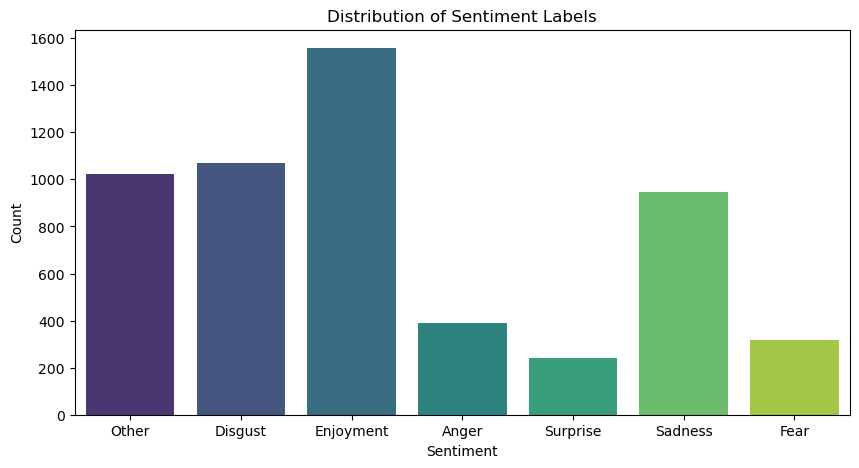

In [7]:
get_basic_info(train_df)

                                            Sentence    Emotion
0  tính tao tao biết , chẳng có chuyện gì có thể ...      Other
1           lại là lào cai , tự hào quê mình quá :))  Enjoyment
2                                     bị từ chối rồi    Sadness
3                         tam đảo trời đẹp các mem à  Enjoyment
4  đọc bình luận của thằng đó không thiếu chữ nào 😂😂      Other
Missing values:
Sentence    0
Emotion     0
dtype: int64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  686 non-null    object
 1   Emotion   686 non-null    object
dtypes: object(2)
memory usage: 10.8+ KB
None
Basic Statistics:
                                                 Sentence    Emotion
count                                                 686        686
unique                                                686          7
top     tính tao t

/tmp/ipykernel_2988094/4094355682.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Emotion'], palette="viridis")


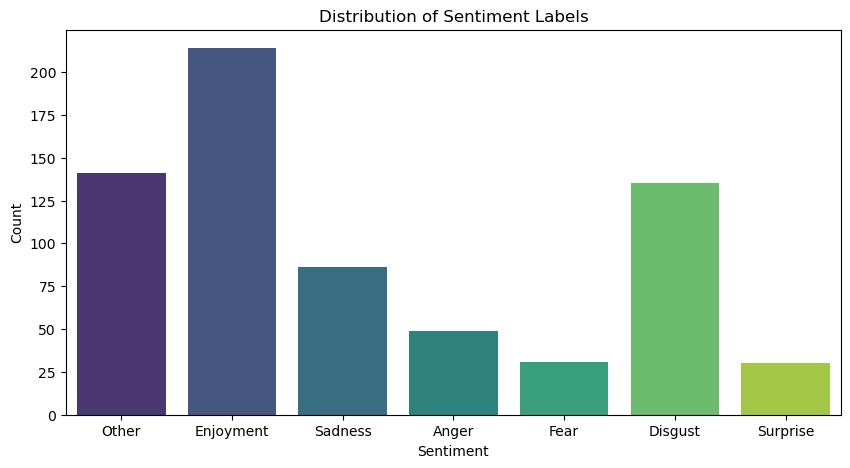

In [8]:
get_basic_info(val_df)

                                            Sentence   Emotion
0                   người ta có bạn bè nhìn vui thật   Sadness
1          cho nghỉ viêc mói đúng sao goi là kỷ luật  Surprise
2                                         kinh vãi 😡   Disgust
3  nhà thì không xa lắm nhưng chưa bao giờ đi vì ...      Fear
4      bố không thích nộp đấy mày thích ý kiến không     Anger
Missing values:
Sentence    0
Emotion     0
dtype: int64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  693 non-null    object
 1   Emotion   693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB
None
Basic Statistics:
                                                 Sentence    Emotion
count                                                 693        693
unique                                                692          7
top     nhìn cái bản mặt

/tmp/ipykernel_2988094/4094355682.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Emotion'], palette="viridis")


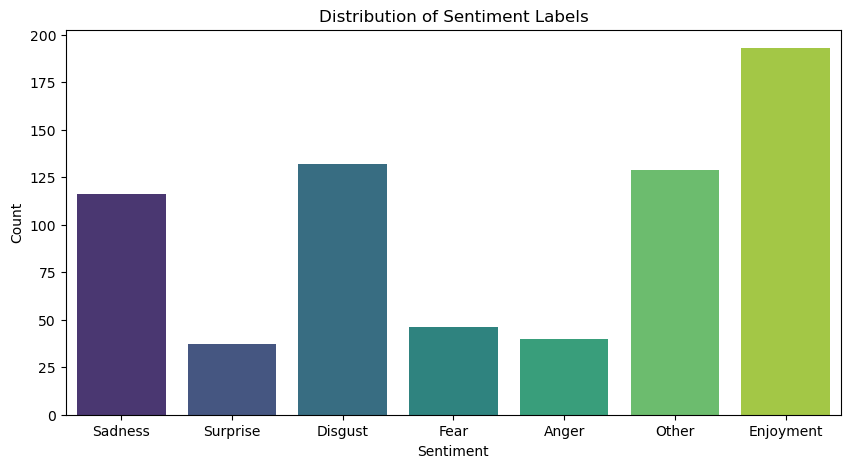

In [9]:
get_basic_info(test_df)

In [10]:
cleaned_train_df = deepcopy(train_df)
cleaned_train_df["CleanedText"] = cleaned_train_df["Sentence"].apply(clean_text)
cleaned_train_df.head()

,Sentence,Emotion,CleanedText
0,cho mình xin bài nhạc tên là gì với ạ,Other,cho mình xin bài nhạc tên là gì với ạ
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust,cho đáng đời con quỷ về nhà lôi con nhà mày r...
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust,lo học đi yêu đương lol gì hay lại thích học ...
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment,uớc gì sau này về già vẫn có thể như cụ này
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [11]:
top_words = get_top_words(cleaned_train_df["CleanedText"])
top_words

[('không', 1130),
 ('tao', 1052),
 ('là', 1006),
 ('có', 1003),
 ('mà', 847),
 ('này', 727),
 ('nó', 717),
 ('đi', 683),
 ('thì', 666),
 ('người', 662),
 ('con', 643),
 ('rồi', 611),
 ('cái', 573),
 ('cho', 552),
 ('per', 537),
 ('được', 522),
 ('cũng', 486),
 ('gì', 472),
 ('như', 472),
 ('làm', 446)]

/tmp/ipykernel_2988094/4292241071.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=words_df['Word'], x=words_df['Count'], palette="magma")


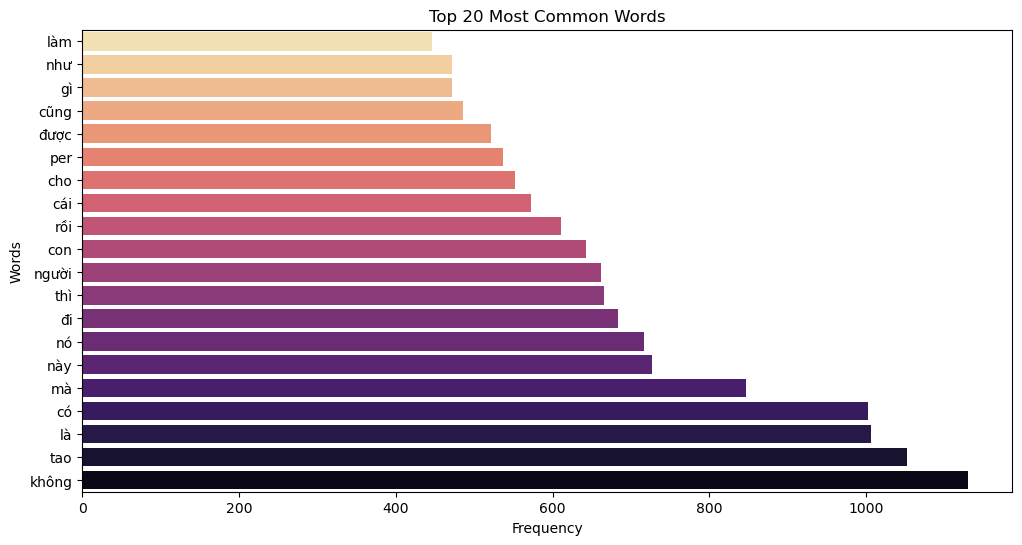

In [12]:
# Convert to DataFrame for visualization
words_df = pd.DataFrame(top_words, columns=["Word", "Count"])
plt.figure(figsize=(12, 6))
sns.barplot(y=words_df["Word"], x=words_df["Count"], palette="magma")
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.gca().invert_yaxis()
plt.show()

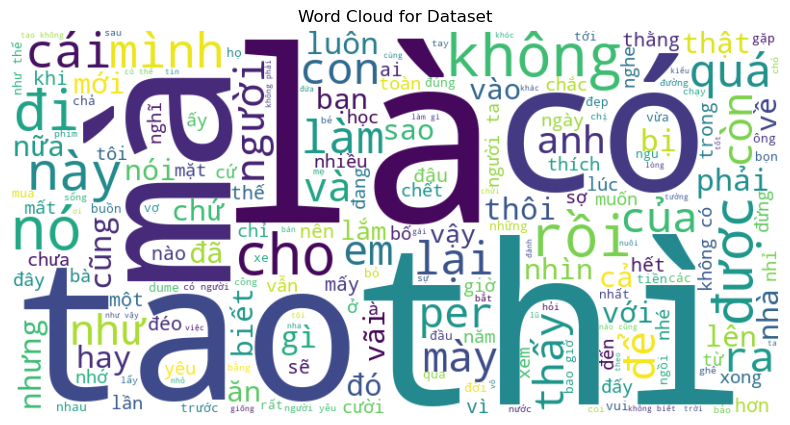

In [13]:
# Generate Wo
text_corpus = "".join(cleaned_train_df["CleanedText"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    text_corpus
)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Dataset")
plt.show()

## Model Setup

In [ ]:
model_ids = [
    "vinai/phobert-base",
    "vinai/phobert-large",
    "vinai/PhoBERT-base-fairseq",
    "vinai/PhoBERT-large-fairseq",
]
model_id = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_id, device=device)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=len(label2idx), id2label=idx2label, label2id=label2idx
).to(device)

In [ ]:
def preprocess_function(sample):
    # Tokenize the text
    # tokenized_text = tokenizer(sample["Sentence"], truncation=True)
    tokenized_text = tokenizer(clean_text(sample["Sentence"]), truncation=True)

    # Map the emotion label to its corresponding index using label2idx
    tokenized_text["labels"] = label2idx[sample["Emotion"]]

    return tokenized_text


tokenized_dataset = dataset.map(preprocess_function)
tokenized_dataset

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["Sentence", "Emotion"])
tokenized_dataset.set_format("torch")
tokenized_dataset["train"].column_names

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

In [ ]:
train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=64, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["validation"], batch_size=64, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=32, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    batch = batch.to(device)
    break
{k: v.shape for k, v in batch.items()}

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

## Training/Validating Process

In [ ]:
num_epochs = 10
learning_rate = 2e-5
weight_decay = 0.01

num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate, no_deprecation_warning=True)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

In [ ]:
metric = evaluate.load("accuracy")

metric

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training loop
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)
        outputs = model(**batch)
        loss = outputs.loss
        # accelerator.backward(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation loop
    model.eval()
    for batch in eval_dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    # Compute and print evaluation metric per epoch
    eval_metric = metric.compute()
    print(f"Epoch {epoch + 1} Evaluation metric: {eval_metric}")

print("Training and evaluation completed!")

## Testing and inference